In [1]:
import os
import sys

os.environ['PYTORCH_CUDA_ALLOC_CONF'] = 'expandable_segments:True'

import io
import torch
import subprocess
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import ticker

from glob import glob
from datetime import datetime
from huggingface_hub import snapshot_download

In [2]:
# repo_dir = "satvision-toa"

# if not os.path.exists(repo_dir):
#     subprocess.run(["git", "clone", "https://github.com/nasa-nccs-hpda/satvision-toa"])
# else:
#     subprocess.run(["git", "-C", repo_dir, "pull"])

In [3]:
sys.path.append("../../../satvision-toa")
from satvision_toa.configs.config import _C, _update_config_from_file
from satvision_toa.models.mim import build_mim_model

In [4]:
from satvision_toa.datasets.ocean_color_dataset import OceanColorDataset
from satvision_toa.models.decoders.ocean_color_decoder import (
    OceanColorUNETV2, OceanColorFCNV3,
    OceanColorFCNV2, OceanColorFCNV2point5
)
from satvision_toa.models.decoders.ocean_color_e2e_decoder import (
    OceanColorFCN, OceanColorUNET
)

from satvision_toa.transforms.ocean_color import (
    GlobalMinMaxNorm, PBMinMaxNorm, ScaleAndOffset
)

from satvision_toa.data_utils.utils_ocean_color import (
    load_config, get_dataloaders, train_model
)

In [5]:
full_dir = "/panfs/ccds02/nobackup/people/ajkerr1/SatVision/OceanColor"

## SV Model
**Note: this will take significant time to execute 100 epochs, which is the default behavior.**

In [6]:
train_dir = os.path.join(full_dir, "chips/ft/chips_ft")
test_dir = os.path.join(full_dir, "chips/ft/val_chips_ft")

In [7]:
config = load_config()
model = build_mim_model(config)
model = OceanColorFCNV2point5(
    swin_encoder=model.encoder, freeze_encoder=True
)

=> merge config from /home/ajkerr1/.cache/huggingface/hub/models--nasa-cisto-data-science-group--downstream-satvision-toa-3dclouds/snapshots/1c6d3b4fba1a476956027e56d5dd9708bdfef0ba/mim_pretrain_swinv2_satvision_giant_128_window08_50ep.yaml


/panfs/ccds02/app/modules/jupyter/ilab/dev/kernel/lib/python3.12/site-packages/torch/functional.py:513: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at /opt/conda/conda-bld/pytorch_1720538439675/work/aten/src/ATen/native/TensorShape.cpp:3609.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


Freezing encoder


In [8]:
train_dataloader, val_dataloader, test_dataloader = get_dataloaders(
    train_dir, test_dir, num_inputs=14, batch_size=64
)

num_epochs = 100
save_every = 20
test_every = 1
save_path = "sv_unet"
pdf_path = "pred_pdfs/svtoa"
metrics_filename = "sv_metrics"
sv_train_losses, sv_val_losses = train_model(
    model, train_dataloader, val_dataloader, test_dataloader, num_epochs=num_epochs, 
    save_path=save_path, save_every=save_every, test_every=test_every, pdf_path=pdf_path, 
    metrics_filename=metrics_filename
)

train & val size: (144, 37)
Decoder weights initialized with Kaiming/Xavier initialization
Starting training for 2 epochs on cuda
Model parameters: 640,583,393


Epoch 1/2 [Train]:   0%|          | 0/6 [00:00<?, ?it/s]/panfs/ccds02/app/modules/jupyter/ilab/dev/kernel/lib/python3.12/site-packages/torch/utils/checkpoint.py:1399: FutureWarning: `torch.cpu.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cpu', args...)` instead.
  with device_autocast_ctx, torch.cpu.amp.autocast(**cpu_autocast_kwargs), recompute_context:  # type: ignore[attr-defined]

Epoch 1/2 [Train]: 100%|██████████| 6/6 [00:33<00:00,  4.46s/it, Loss=0.167457, Avg=0.166989, LR=1.00e-04]
                                                                                                          
Epoch 1/2 [Val]: 100%|██████████| 1/1 [00:01<00:00,  1.61s/it, Loss=0.299704, MAE=0.288147]
                                                                                           

Starting testing...



Training Progress:  50%|█████     | 1/2 [00:38<00:38, 38.07s/it, Train_Loss=0.1670, Val_Loss=0.2997, Val_MAE=0.2881, Time=38.1s]

Plots saved to pred_pdfs/svtoa/preds_day_2025_07_30_time_10_52_1ep.pdf



Epoch 2/2 [Train]:   0%|          | 0/6 [00:00<?, ?it/s]/panfs/ccds02/app/modules/jupyter/ilab/dev/kernel/lib/python3.12/site-packages/torch/utils/checkpoint.py:1399: FutureWarning: `torch.cpu.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cpu', args...)` instead.
  with device_autocast_ctx, torch.cpu.amp.autocast(**cpu_autocast_kwargs), recompute_context:  # type: ignore[attr-defined]

Epoch 2/2 [Train]: 100%|██████████| 6/6 [00:32<00:00,  4.43s/it, Loss=0.155329, Avg=0.141929, LR=5.05e-05]
                                                                                                          
Epoch 2/2 [Val]: 100%|██████████| 1/1 [00:01<00:00,  1.66s/it, Loss=0.221225, MAE=0.212764]
                                                                                           

Starting testing...



Training Progress: 100%|██████████| 2/2 [01:15<00:00, 37.83s/it, Train_Loss=0.1419, Val_Loss=0.2212, Val_MAE=0.2128, Time=37.6s]

Plots saved to pred_pdfs/svtoa/preds_day_2025_07_30_time_10_53_2ep.pdf

Training completed!
Best validation loss: 0.221225


## Plain UNET

In [9]:
train_dir = os.path.join(full_dir, "chips/e2e/chips_6_27")
test_dir = os.path.join(full_dir, "chips/e2e/val_chips_e2e")

In [10]:
model = OceanColorUNET(in_channels=12, out_channels=1)

In [11]:
# ADJUST FOR TRAINING UNET VS SATVISION
train_dataloader, val_dataloader, test_dataloader = get_dataloaders(
    train_dir, test_dir, num_inputs=12, batch_size=64
)

num_epochs = 100
save_every = 20
test_every = 1
save_path = "e2e_unet"
pdf_path = "pred_pdfs/e2e"
metrics_filename = "e2e_metrics"
e2e_train_losses, e2e_val_losses = train_model(
    model, train_dataloader, val_dataloader, test_dataloader, num_epochs=num_epochs, 
    save_path=save_path, save_every=save_every, test_every=test_every, pdf_path=pdf_path, 
    metrics_filename=metrics_filename
)

train & val size: (144, 37)
Starting training for 10 epochs on cuda
Model parameters: 1,817,217


Epoch 1/10 [Train]:  83%|████████▎ | 5/6 [00:03<00:00,  1.54it/s, Loss=0.210940, Avg=0.246560, LR=1.00e-04]
                                                                                                           
Epoch 1/10 [Val]: 100%|██████████| 1/1 [00:00<00:00,  1.96it/s, Loss=0.289212, MAE=0.281148]
                                                                                            

Starting testing...



Training Progress:  10%|█         | 1/10 [00:06<01:00,  6.69s/it, Train_Loss=0.2466, Val_Loss=0.2892, Val_MAE=0.2811, Time=6.7s]

Plots saved to pred_pdfs/e2e/preds_day_2025_07_30_time_10_53_1ep.pdf



Epoch 2/10 [Train]:  83%|████████▎ | 5/6 [00:03<00:00,  1.55it/s, Loss=0.258757, Avg=0.222016, LR=9.76e-05]
                                                                                                           
Epoch 2/10 [Val]: 100%|██████████| 1/1 [00:00<00:00,  2.00it/s, Loss=0.286859, MAE=0.278934]
                                                                                            

Starting testing...



Training Progress:  20%|██        | 2/10 [00:13<00:53,  6.68s/it, Train_Loss=0.2220, Val_Loss=0.2869, Val_MAE=0.2789, Time=6.7s]

Plots saved to pred_pdfs/e2e/preds_day_2025_07_30_time_10_53_2ep.pdf



Epoch 3/10 [Train]:  83%|████████▎ | 5/6 [00:03<00:00,  1.54it/s, Loss=0.243199, Avg=0.205860, LR=9.05e-05]
                                                                                                           
Epoch 3/10 [Val]: 100%|██████████| 1/1 [00:00<00:00,  1.95it/s, Loss=0.272512, MAE=0.264841]
                                                                                            

Starting testing...



Training Progress:  30%|███       | 3/10 [00:20<00:47,  6.82s/it, Train_Loss=0.2059, Val_Loss=0.2725, Val_MAE=0.2648, Time=7.0s]

Plots saved to pred_pdfs/e2e/preds_day_2025_07_30_time_10_53_3ep.pdf



Epoch 4/10 [Train]:  83%|████████▎ | 5/6 [00:03<00:00,  1.54it/s, Loss=0.248192, Avg=0.195810, LR=7.96e-05]
                                                                                                           
Epoch 4/10 [Val]: 100%|██████████| 1/1 [00:00<00:00,  1.89it/s, Loss=0.249582, MAE=0.242151]
                                                                                            

Starting testing...



Training Progress:  40%|████      | 4/10 [00:27<00:40,  6.78s/it, Train_Loss=0.1958, Val_Loss=0.2496, Val_MAE=0.2422, Time=6.7s]

Plots saved to pred_pdfs/e2e/preds_day_2025_07_30_time_10_53_4ep.pdf



Epoch 5/10 [Train]:  83%|████████▎ | 5/6 [00:03<00:00,  1.54it/s, Loss=0.244189, Avg=0.190809, LR=6.58e-05]
                                                                                                           
Epoch 5/10 [Val]: 100%|██████████| 1/1 [00:00<00:00,  1.89it/s, Loss=0.227454, MAE=0.220289]
                                                                                            

Starting testing...



Training Progress:  50%|█████     | 5/10 [00:33<00:33,  6.76s/it, Train_Loss=0.1908, Val_Loss=0.2275, Val_MAE=0.2203, Time=6.7s]

Plots saved to pred_pdfs/e2e/preds_day_2025_07_30_time_10_53_5ep.pdf



Epoch 6/10 [Train]:  83%|████████▎ | 5/6 [00:03<00:00,  1.54it/s, Loss=0.174477, Avg=0.177644, LR=5.05e-05]
                                                                                                           
Epoch 6/10 [Val]: 100%|██████████| 1/1 [00:00<00:00,  1.90it/s, Loss=0.220398, MAE=0.213434]
                                                                                            

Starting testing...



Training Progress:  60%|██████    | 6/10 [00:40<00:27,  6.88s/it, Train_Loss=0.1776, Val_Loss=0.2204, Val_MAE=0.2134, Time=7.1s]

Plots saved to pred_pdfs/e2e/preds_day_2025_07_30_time_10_53_6ep.pdf



Epoch 7/10 [Train]:  83%|████████▎ | 5/6 [00:03<00:00,  1.54it/s, Loss=0.228512, Avg=0.183088, LR=3.52e-05]
                                                                                                           
Epoch 7/10 [Val]: 100%|██████████| 1/1 [00:00<00:00,  1.80it/s, Loss=0.209872, MAE=0.203065]
                                                                                            

Starting testing...



Training Progress:  70%|███████   | 7/10 [00:47<00:20,  6.86s/it, Train_Loss=0.1831, Val_Loss=0.2099, Val_MAE=0.2031, Time=6.8s]

Plots saved to pred_pdfs/e2e/preds_day_2025_07_30_time_10_53_7ep.pdf



Epoch 8/10 [Train]:  83%|████████▎ | 5/6 [00:03<00:00,  1.53it/s, Loss=0.210192, Avg=0.175091, LR=2.14e-05]
                                                                                                           
Epoch 8/10 [Val]: 100%|██████████| 1/1 [00:00<00:00,  1.76it/s, Loss=0.203400, MAE=0.196703]
                                                                                            

Starting testing...



Training Progress:  80%|████████  | 8/10 [00:54<00:13,  6.88s/it, Train_Loss=0.1751, Val_Loss=0.2034, Val_MAE=0.1967, Time=6.9s]

Plots saved to pred_pdfs/e2e/preds_day_2025_07_30_time_10_54_8ep.pdf



Epoch 9/10 [Train]:  83%|████████▎ | 5/6 [00:03<00:00,  1.53it/s, Loss=0.168593, Avg=0.167282, LR=1.05e-05]
                                                                                                           
Epoch 9/10 [Val]: 100%|██████████| 1/1 [00:00<00:00,  1.73it/s, Loss=0.197659, MAE=0.191042]
                                                                                            

Starting testing...



Training Progress:  90%|█████████ | 9/10 [01:02<00:07,  7.04s/it, Train_Loss=0.1673, Val_Loss=0.1977, Val_MAE=0.1910, Time=7.4s]

Plots saved to pred_pdfs/e2e/preds_day_2025_07_30_time_10_54_9ep.pdf



Epoch 10/10 [Train]:  83%|████████▎ | 5/6 [00:03<00:00,  1.53it/s, Loss=0.176688, Avg=0.170661, LR=3.42e-06]
                                                                                                            
Epoch 10/10 [Val]: 100%|██████████| 1/1 [00:00<00:00,  1.72it/s, Loss=0.192189, MAE=0.185611]
                                                                                             

Starting testing...



Training Progress: 100%|██████████| 10/10 [01:09<00:00,  6.90s/it, Train_Loss=0.1707, Val_Loss=0.1922, Val_MAE=0.1856, Time=7.0s]

Plots saved to pred_pdfs/e2e/preds_day_2025_07_30_time_10_54_10ep.pdf

Training completed!
Best validation loss: 0.192189


## Viz Epoch-level Metrics
*Metrics other than loss have been divided into epochs 0-20 and 20 onward for visual clarity.*

### SatVision Metrics

#### Train, Val Losses

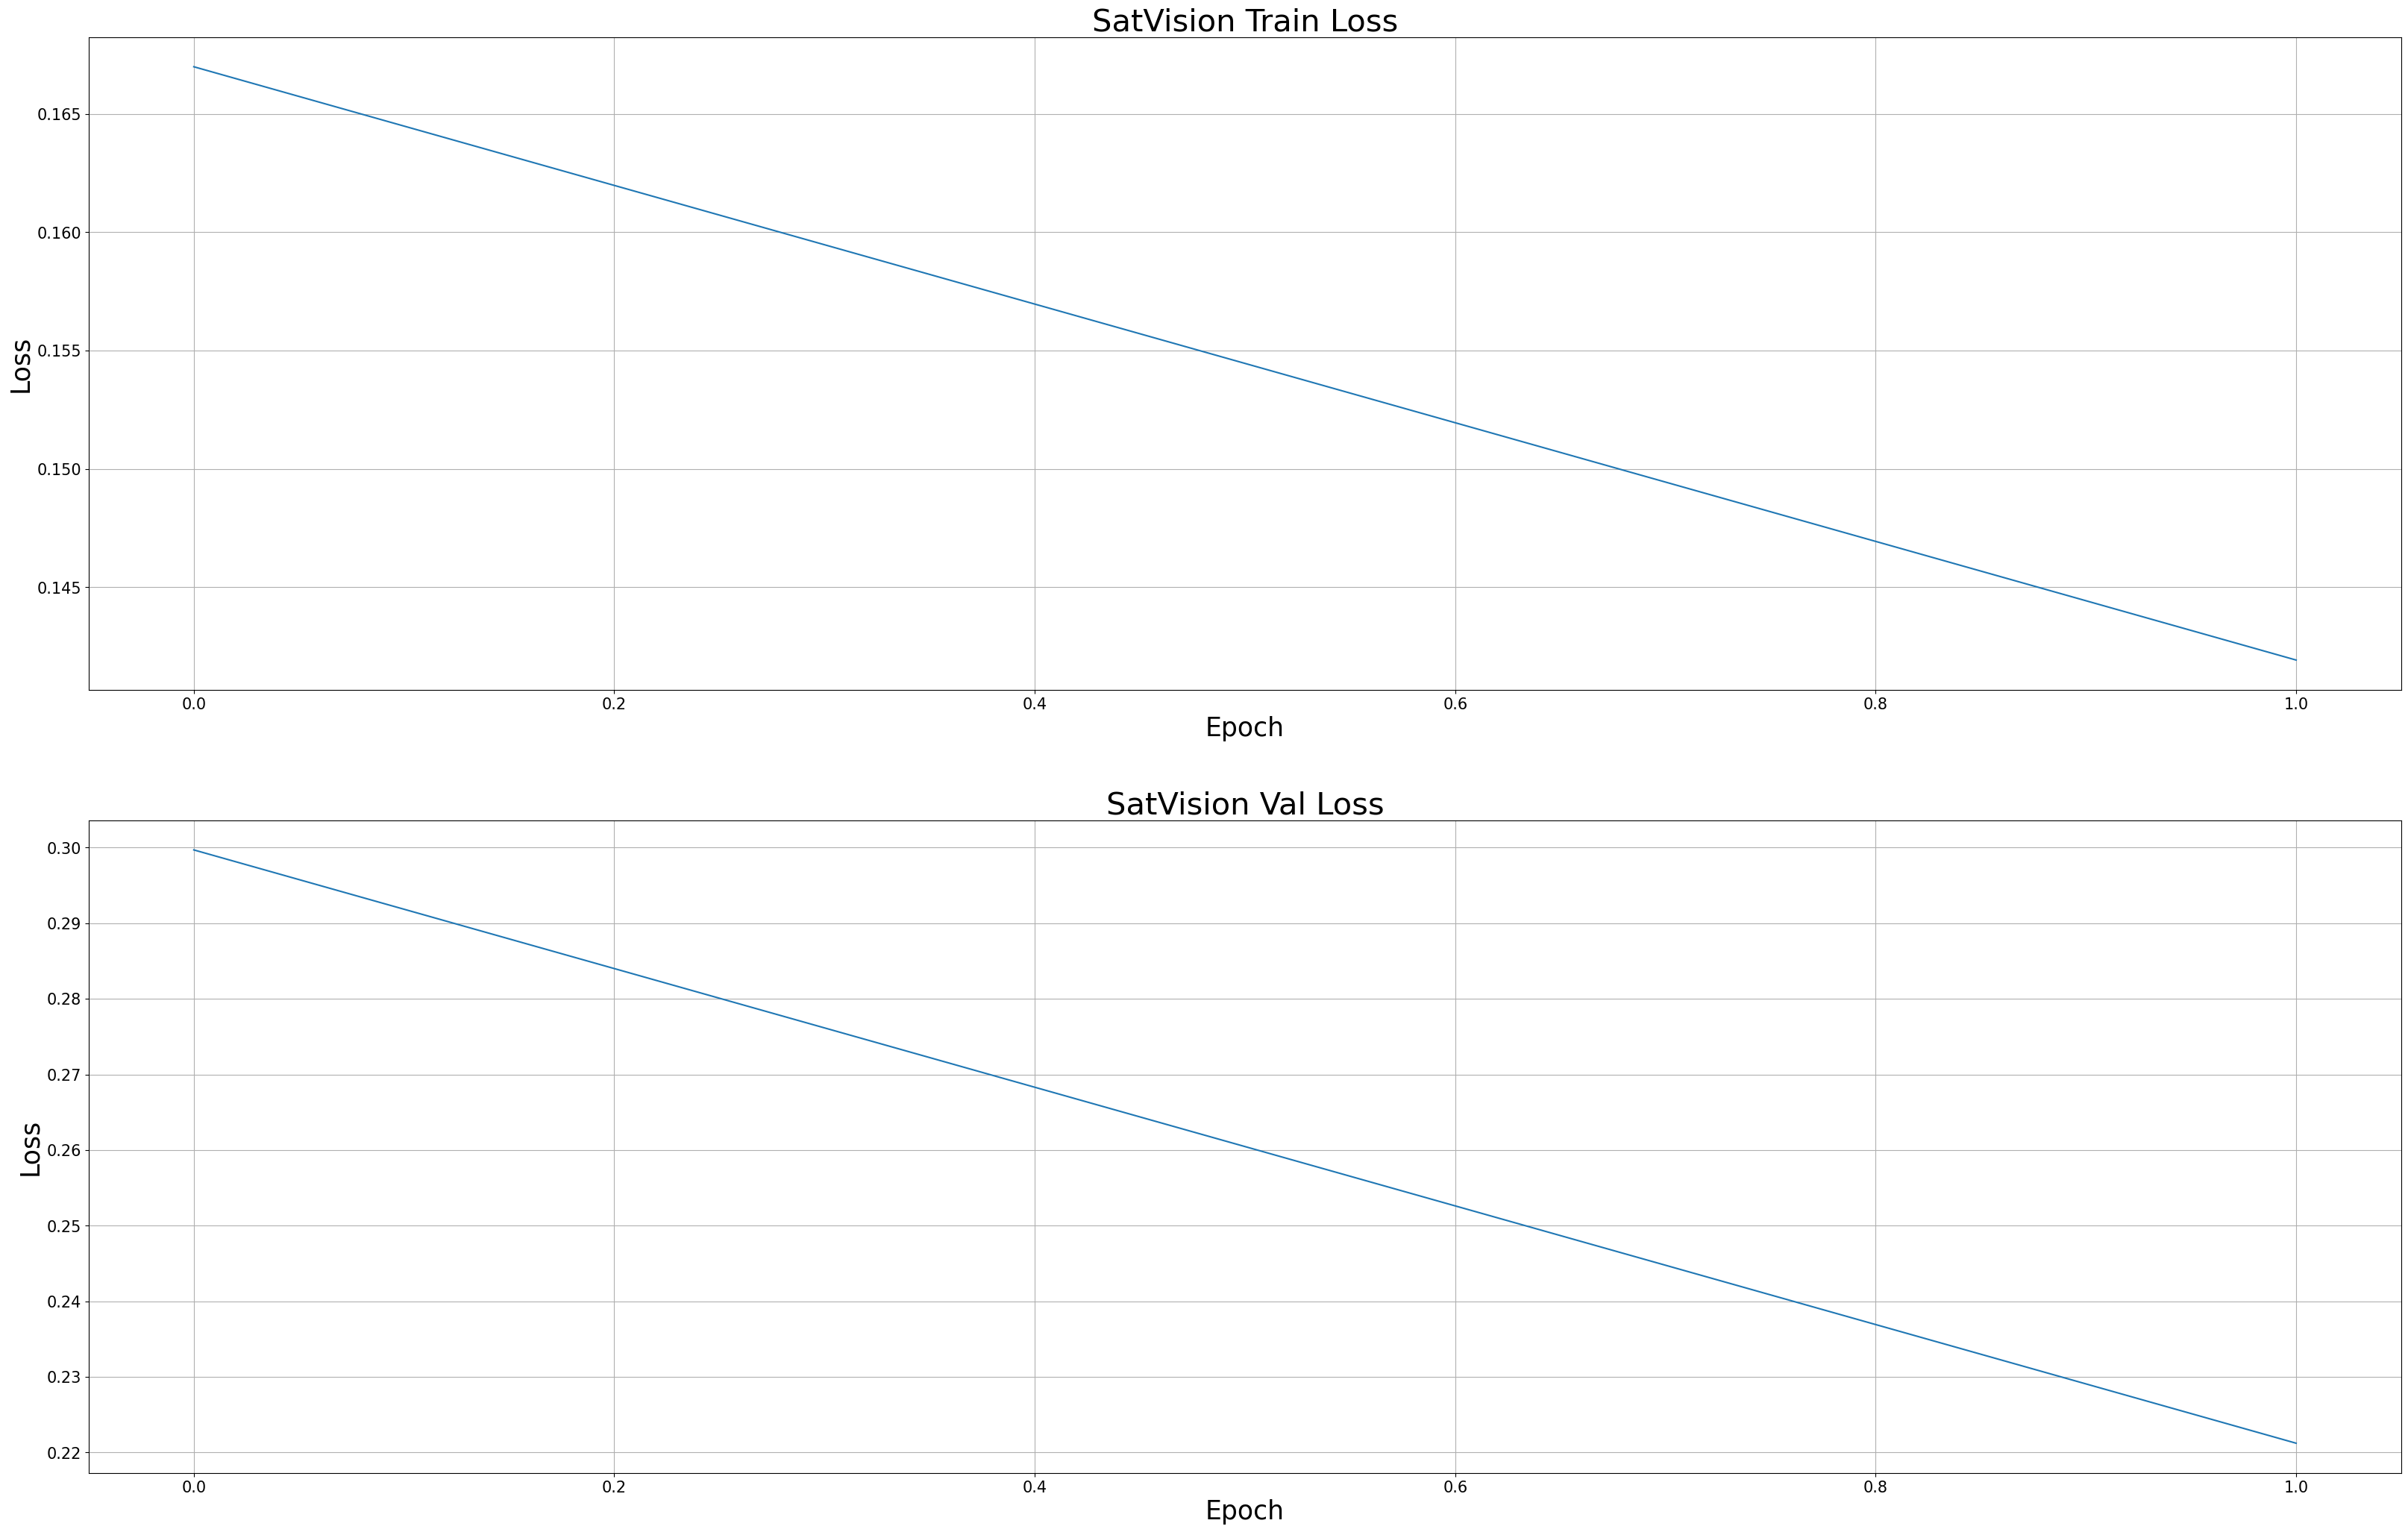

In [12]:
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(40, 25))
ax1.plot(sv_train_losses)
ax2.plot(sv_val_losses)
ax1.set_xlabel("Epoch", fontsize=25)
ax2.set_xlabel("Epoch", fontsize=25)
ax1.set_ylabel("Loss", fontsize=25)
ax2.set_ylabel("Loss", fontsize=25)
ax1.tick_params(axis='both', which='major', labelsize=15)
ax2.tick_params(axis='both', which='major', labelsize=15)
ax1.set_title("SatVision Train Loss", fontsize=30)
ax2.set_title("SatVision Val Loss", fontsize=30)
ax1.grid()
ax2.grid()
plt.show()

#### R2, RMSE, SSIM, PSNR

In [13]:
sv_metrics_filename = 'sv_metrics_epoch_avg_metrics.csv'
df = pd.read_csv(sv_metrics_filename)
df = df[['epoch', 'r2', 'rmse', 'ssim', 'psnr']]
df1 = df.iloc[0:21]
df2 = df.iloc[21:]

fig, axes = plt.subplots(2, 2, figsize=(10, 6))
axes = np.array(axes).flatten()
metric_columns = ['r2', 'rmse', 'ssim', 'psnr']
for idx, metric in enumerate(metric_columns):
    axes[idx].plot(df['epoch'], df[metric], label=metric)
    axes[idx].set_title(f'SV {metric.upper()} vs Epoch')
    axes[idx].set_xlabel('Epoch')
    axes[idx].set_ylabel(metric.upper())
    axes[idx].grid(True, alpha=0.3)
    axes[idx].xaxis.set_major_formatter(ticker.FormatStrFormatter('%d'))
    axes[idx].yaxis.set_major_formatter(ticker.FormatStrFormatter('%.2f'))

plt.tight_layout()
plt.show()

FileNotFoundError: [Errno 2] No such file or directory: 'sv_metrics_epoch_avg_metrics.csv'

### E2E Metrics

#### Train, Val Losses

In [ ]:
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(40, 25))
ax1.plot(e2e_train_losses)
ax2.plot(e2e_val_losses)
ax1.set_xlabel("Epoch", fontsize=25)
ax2.set_xlabel("Epoch", fontsize=25)
ax1.set_ylabel("Loss", fontsize=25)
ax2.set_ylabel("Loss", fontsize=25)
ax1.tick_params(axis='both', which='major', labelsize=15)
ax2.tick_params(axis='both', which='major', labelsize=15)
ax1.set_title("E2E Training Loss", fontsize=30)
ax2.set_title("E2E Validation Loss", fontsize=30)
ax1.grid()
ax2.grid()
plt.show()

#### R2, RMSE, SSIM, PSNR

In [ ]:
e2e_metrics_filename = 'e2e_metrics_epoch_avg_metrics.csv'
df = pd.read_csv(e2e_metrics_filename)
df = df[['epoch', 'r2', 'rmse', 'ssim', 'psnr']]
df1 = df.iloc[0:21]
df2 = df.iloc[21:]

fig, axes = plt.subplots(2, 2, figsize=(10, 6))
axes = np.array(axes).flatten()
metric_columns = ['r2', 'rmse', 'ssim', 'psnr']
for idx, metric in enumerate(metric_columns):
    axes[idx].plot(df['epoch'], df[metric], label=metric)
    axes[idx].set_title(f'E2E {metric.upper()} vs Epoch')
    axes[idx].set_xlabel('Epoch')
    axes[idx].set_ylabel(metric.upper())
    axes[idx].grid(True, alpha=0.3)
    axes[idx].xaxis.set_major_formatter(ticker.FormatStrFormatter('%d'))
    axes[idx].yaxis.set_major_formatter(ticker.FormatStrFormatter('%.2f'))

plt.tight_layout()
plt.show()